## Скачивание даты и импорт библиотек

In [1]:
!pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/content/kaggle.json
!kaggle datasets download -d grouplens/movielens-20m-dataset


     |████████████████████████████████| 58 kB 1.1 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 78 kB 3.1 MB/s             
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73053 sha256=4450e330b2e775d29ab2be8fc4d9d79e293050e0cc0c6cf0718e731b5f3af1a4
  Stored in directory: /Users/Liza/Library/Caches/pip/wheels/ac/b2/c3/fa4706d469b5879105991d1c8be9a3c2ef329ba9fe2ce5085e
Successfully built kaggle
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip' command.
chmod: /Users/Liza/content/kaggle.json: No such file or directory
100%|███████████████████████████████████████▉| 195M/195M [00:22<00:00, 11.5MB/s]
100%|████████████████████████████████████████| 195M/195M [00:22<00:00, 9.07MB/s]


In [7]:
!unzip movielens-20m-dataset.zip

Archive:  movielens-20m-dataset.zip
  inflating: genome_scores.csv       
  inflating: genome_tags.csv         
  inflating: link.csv                
  inflating: movie.csv               
  inflating: rating.csv              
  inflating: tag.csv                 


In [3]:
!pip install surprise
!pip install pyspark

     |████████████████████████████████| 11.8 MB 1.8 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp39-cp39-macosx_10_9_x86_64.whl size=770503 sha256=f6e9ee4eca8d8bab588d91d387c33ffb4cfa30bb0dc662edb7584af14c58cf19
  Stored in directory: /Users/Liza/Library/Caches/pip/wheels/6b/10/c9/7f607c8cb522ef378844f41e63b30d7181a6495d2c1ae514e9
Successfully built scikit-surprise
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [315]:
!pip install pandas_profiling

     |████████████████████████████████| 261 kB 2.8 MB/s            
     |████████████████████████████████| 2.9 MB 7.8 MB/s            
     |████████████████████████████████| 3.1 MB 5.9 MB/s            
     |████████████████████████████████| 694 kB 6.8 MB/s            
     |████████████████████████████████| 102 kB 3.9 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 2.0 MB 4.2 MB/s            
     |████████████████████████████████| 812 kB 6.6 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 4.4 MB 3.2 MB/s            
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27085 sha256=8c2aaf5be0beb258dceb6d27f9b5c9fa86bbd0c1bd4aee8f728c2e04d82819ae
  Stored in directory: /Users/Liza/Library/Caches/pip/wheels/1d/05/04/c6d7d3b66539d9e659ac6dfe81e2d0fd4c1a8316cc5a403300
  Created wheel for imagehash: filename=ImageHash-4.2.1-py2.py3-none-any.whl size=295198 sha256=3cf4

In [373]:
!pip install lightfm

     |████████████████████████████████| 310 kB 2.8 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.16-cp39-cp39-macosx_10_9_x86_64.whl size=448364 sha256=01ca1cd87debf090d4e32edf719556e6505101fbd40d3b7786dfe918056be668
  Stored in directory: /Users/Liza/Library/Caches/pip/wheels/d7/75/52/e42e5f9cd86d4902a352aff4dadde75ec041af713ffcf3ed05
Successfully built lightfm
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [908]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
from tqdm import tqdm
import pandas_profiling
from lightfm import LightFM
from lightfm import evaluation
from sklearn.metrics import ndcg_score
from lightfm import cross_validation
import scipy
import matplotlib.pyplot as plt
from surprise import Reader, Dataset, SVD
from sklearn.metrics import mean_squared_error
from surprise.model_selection import split, cross_validate
from pyspark.sql import SparkSession
from pyspark.sql import functions as fn
from lightfm.data import Dataset
from pyspark.sql.functions import col
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

random.seed(42)

In [9]:
movie = pd.read_csv('movie.csv')
rating = pd.read_csv('rating.csv')
tag = pd.read_csv('tag.csv')
genome_tags = pd.read_csv('genome_tags.csv')
genome_scores = pd.read_csv('genome_scores.csv')
link = pd.read_csv('link.csv')


# Анализ данных

In [10]:
movie.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [11]:
rating.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [12]:
tag.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19
3,65,521,noir thriller,2013-05-10 01:39:43
4,65,592,dark hero,2013-05-10 01:41:18


In [13]:
genome_tags.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [14]:
genome_scores.head()

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


In [15]:
link.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [16]:
genres = movie['genres'].str.split('|', expand=True)

# достаточно рассмотреть одну колонку, чтобы узнать все жанры
genres[0].unique()

array(['Adventure', 'Comedy', 'Action', 'Drama', 'Crime', 'Children',
       'Mystery', 'Documentary', 'Animation', 'Thriller', 'Horror',
       'Fantasy', 'Western', 'Film-Noir', 'Romance', 'War', 'Sci-Fi',
       'Musical', 'IMAX', '(no genres listed)'], dtype=object)

In [17]:
# колонки в общую таблицу
for mov in genres[0].unique():
  movie[mov] = 0

# словарь с индексами для удобства
genres_dict = {}
for g, genre in enumerate(genres[0].unique()):
  genres_dict[genre] = g

In [18]:
result = np.array([[0] * len(genres[0].unique())] * movie.shape[0])
# сделаем бинарную таблицу с жанрами по фильмам
for id in range(movie.shape[0]):
  g = movie['genres'][id].split('|')
  for genre in g:
    result[id][genres_dict[genre]] = 1

In [19]:
# добавим получившуюся таблицу с общую
movie[genres[0].unique()] = result
movie.head()

,movieId,title,genres,Adventure,Comedy,Action,Drama,Crime,Children,Mystery,...,Horror,Fantasy,Western,Film-Noir,Romance,War,Sci-Fi,Musical,IMAX,(no genres listed)
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,1,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
for genre in genres[0].unique():
    print(movie.value_counts(genre), '\n')

Adventure
0    24949
1     2329
dtype: int64 

Comedy
0    18904
1     8374
dtype: int64 

Action
0    23758
1     3520
dtype: int64 

Drama
0    13934
1    13344
dtype: int64 

Crime
0    24339
1     2939
dtype: int64 

Children
0    26139
1     1139
dtype: int64 

Mystery
0    25764
1     1514
dtype: int64 

Documentary
0    24807
1     2471
dtype: int64 

Animation
0    26251
1     1027
dtype: int64 

Thriller
0    23100
1     4178
dtype: int64 

Horror
0    24667
1     2611
dtype: int64 

Fantasy
0    25866
1     1412
dtype: int64 

Western
0    26602
1      676
dtype: int64 

Film-Noir
0    26948
1      330
dtype: int64 

Romance
0    23151
1     4127
dtype: int64 

War
0    26084
1     1194
dtype: int64 

Sci-Fi
0    25535
1     1743
dtype: int64 

Musical
0    26242
1     1036
dtype: int64 

IMAX
0    27082
1      196
dtype: int64 

(no genres listed)
0    27032
1      246
dtype: int64 



In [21]:
# Добавим средний рейтинг
movie['rating'] = rating.groupby(by='movieId').mean()['rating']
movie['rating']

0             NaN
1        3.921240
2        3.211977
3        3.151040
4        2.861393
           ...   
27273    2.750000
27274    2.937500
27275         NaN
27276    3.900000
27277    2.333333
Name: rating, Length: 27278, dtype: float64

In [23]:
# сделаем колонку года
year = movie['title'].str.findall('\((\d{4})\)').str.get(0)
movie['Year'] = year

In [25]:
# сделаем отдельную таблицу с тегами
movie_opinion = movie.copy()

In [26]:
movie_opinion_ = pd.merge(movie_opinion, tag, left_on='movieId', right_on='movieId')

In [27]:
tags_ = pd.DataFrame(movie_opinion_.groupby('movieId').count()['tag'])
movie_opinion = pd.merge(movie_opinion, tags_, left_on='movieId', right_on='movieId')


In [28]:
movie_opinion.head()

,movieId,title,genres,Adventure,Comedy,Action,Drama,Crime,Children,Mystery,...,Film-Noir,Romance,War,Sci-Fi,Musical,IMAX,(no genres listed),rating,Year,tag
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,NaN,1995,436
1,2,Jumanji (1995),Adventure|Children|Fantasy,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,3.921240,1995,123
2,3,Grumpier Old Men (1995),Comedy|Romance,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,3.211977,1995,18
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,0,1,0,1,0,0,0,...,0,1,0,0,0,0,0,3.151040,1995,6
4,5,Father of the Bride Part II (1995),Comedy,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,2.861393,1995,22


In [32]:
np.mean(movie_opinion[movie_opinion.columns[3:-3]].sum(axis=1)) # в среднем по 2 жанра у фильма

2.0599641852136097

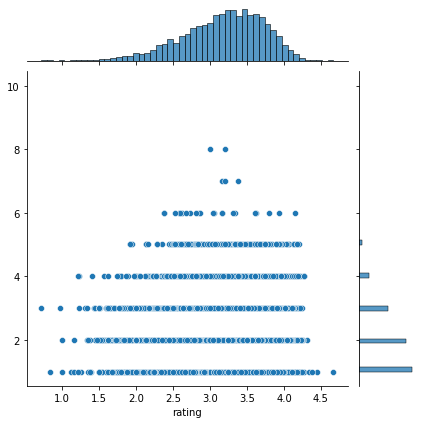

In [33]:
sns.jointplot(data=movie_opinion,
              x='rating',
              y=movie_opinion[movie_opinion.columns[3:-3]].sum(axis=1)) # распределение оценок в зависимости от количества жанров

In [34]:
genres = movie['genres'].str.split('|', expand=True) # посчитаем количество жанров
genres['Year'] = movie['Year']

In [718]:
genres.fillna(0, inplace=True)
genres.head()

,0,1,2,3,4,5,6,7,8,9,Year
0,Adventure,Animation,Children,Comedy,Fantasy,0,0,0,0,0,1995
1,Adventure,Children,Fantasy,0,0,0,0,0,0,0,1995
2,Comedy,Romance,0,0,0,0,0,0,0,0,1995
3,Comedy,Drama,Romance,0,0,0,0,0,0,0,1995
4,Comedy,0,0,0,0,0,0,0,0,0,1995


In [40]:
all_genres_sum = pd.DataFrame(index=pd.DataFrame(genres[0].value_counts()).index)
for i in range(10):
      all_genres_sum[i] = pd.DataFrame(genres[i].value_counts())

In [41]:
all_genres_sum.fillna(0, inplace=True) # по иерархии
all_genres_sum

,0,1,2,3,4,5,6,7,8,9
Drama,7875,4452.0,891.0,113.0,13.0,0.0,0.0,0.0,0.0,0.0
Comedy,6793,1099.0,348.0,116.0,18.0,0.0,0.0,0.0,0.0,0.0
Action,3520,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Documentary,2247,206.0,16.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
Crime,1617,1035.0,246.0,37.0,4.0,0.0,0.0,0.0,0.0,0.0
Horror,1380,919.0,255.0,49.0,7.0,0.0,1.0,0.0,0.0,0.0
Adventure,1357,972.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Animation,571,362.0,94.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Children,414,462.0,229.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0
Thriller,279,1301.0,1598.0,754.0,205.0,30.0,6.0,4.0,1.0,0.0


In [42]:
all_genres_sum.sum(axis=1) # сложим все и построим график

Drama                 13344.0
Comedy                 8374.0
Action                 3520.0
Documentary            2471.0
Crime                  2939.0
Horror                 2611.0
Adventure              2329.0
Animation              1027.0
Children               1139.0
Thriller               4178.0
(no genres listed)      246.0
Western                 676.0
Sci-Fi                 1743.0
Mystery                1514.0
Romance                4127.0
Fantasy                1412.0
Musical                1036.0
Film-Noir               330.0
War                    1194.0
IMAX                    196.0
dtype: float64

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 [Text(0, 0, 'Drama'),
  Text(1, 0, 'Comedy'),
  Text(2, 0, 'Action'),
  Text(3, 0, 'Documentary'),
  Text(4, 0, 'Crime'),
  Text(5, 0, 'Horror'),
  Text(6, 0, 'Adventure'),
  Text(7, 0, 'Animation'),
  Text(8, 0, 'Children'),
  Text(9, 0, 'Thriller'),
  Text(10, 0, '(no genres listed)'),
  Text(11, 0, 'Western'),
  Text(12, 0, 'Sci-Fi'),
  Text(13, 0, 'Mystery'),
  Text(14, 0, 'Romance'),
  Text(15, 0, 'Fantasy'),
  Text(16, 0, 'Musical'),
  Text(17, 0, 'Film-Noir'),
  Text(18, 0, 'War'),
  Text(19, 0, 'IMAX')])

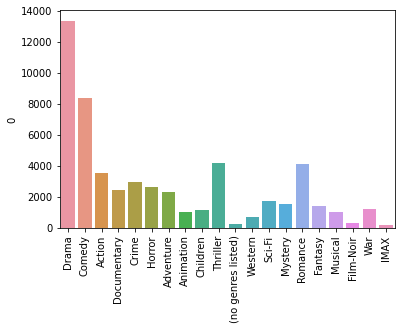

In [43]:
sns.barplot(pd.DataFrame(all_genres_sum.sum(axis=1)).index, pd.DataFrame(all_genres_sum.sum(axis=1))[0])
plt.xticks(rotation=90)

In [686]:
movie_ = movie.copy()
movie_['rating'].replace(np.nan, 0, inplace=True)

In [405]:
# построим общий html отчет (будет прикреплен на гите)
profile = pandas_profiling.ProfileReport(movie_[movie_.columns[3:]])
profile.to_file('movie_.html')

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Коллаборативный метод

**Какие будем использовать метрики?** \
$RMSE$ - для обучения моделей, дополнительно - $nDCG$ для проверки качества ранжирования\
Для оценки предесказания качества рейтинга можно использовать любые регрессионные метрики. Я выбрала
RMSE, поскольку она легко интерпретируется, что полезно для нашей задачи и MAE, которая покажет результат в том же масштабе, но с меньшим смещением на выбросах.

$RMSE = \sqrt{\frac{1}{N}\sum_{i=1}^{N}(y_i-a(x_i))^2}$, \
$y_i - test, a(x)_i - prediction$ 

$MAE = \frac{1}{N}\sum_{i=1}^{N}|y_i-a(x_i)|$ 

$nDCG = \sum_{p=1}^k g(r_{ui_{p}})d(p)$,\
$u - user, i - item, g(r_{ui_{p}}) - prediction, d(p) - \text{position penalty}$


В датасете 138493 пользователей и 26744 фильмов. Матрица пользователь-фильм будет, соответственно, 138493 x 26744. Огромная! 
Для дальнейшей проверки моделей буду использовать урезенный датасет на 1000 рандомных пользователей.

In [45]:
users = rating.userId.unique()
movid = rating.movieId.unique()

print('количество пользователей:', len(users))
print('количество фильмов:', len(movid))

количество пользователей: 138493
количество фильмов: 26744


In [635]:
test, train = pd.DataFrame(columns=rating.columns), pd.DataFrame(columns=rating.columns)
TEST_SIZE = 0.2

In [48]:
np.random.shuffle(users)
users_1000 = users[:1000]

In [ ]:
rating_1000 = rating[rating.userId.isin(users_1000)]
# rating_1000.to_csv('rating_1000.csv', index=False)

трейн и тест выборку делаю по дате выбора! Для каждого пользователя считаем 80% фильмов, которые он уже посмотрел,
20% оставляем на проверку. Да, этот метод не учитывает, что разные люди посмотрели разный процент фильмов к одному сроку,
поэтому модель не учитывает тренды и тд, но! У нас модельки простенькие, поэтому норм!

In [636]:
test_size_dict_1000 = {}
N_1000 = {}

for user in tqdm(users_1000):
      user_story = rating[rating.userId == user]
      n = len(user_story)
      N_1000[user] = n
      test_size_dict_1000[user] = int(n * TEST_SIZE)
      user_story = user_story.sort_values('timestamp').reset_index()
      user_story.drop('index', axis=1, inplace=True)
      dum_test = user_story[n-1-test_size_dict_1000[user]:] 
      dum_train = user_story[:n-2-test_size_dict_1000[user]]
      test = pd.concat([test, dum_test])
      train = pd.concat([train, dum_train])


100%|███████████████████████████████████████| 1000/1000 [00:29<00:00, 33.35it/s]


Сперва протестирем SVD модель. Для этого воспользуемся библиотекой Surprise. Для SVD нам не нужно подбирать гиперпараметры

In [722]:
reader = Reader()
algo = SVD()
data = Dataset.load_from_df(train[['userId', 'movieId', 'rating']], reader)

In [723]:
# Обучим модель на кросс-валидации на трейновой выборке
# средняя RMSE составляет 0.89, то есть модель в среднем ошибается меньше чем на балл

cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True) 

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8938  0.8915  0.8986  0.9026  0.8963  0.8966  0.0038  
MAE (testset)     0.6860  0.6851  0.6904  0.6912  0.6882  0.6882  0.0024  
Fit time          4.96    4.76    4.70    5.13    4.73    4.85    0.16    
Test time         0.20    0.12    0.12    0.14    0.14    0.15    0.03    


{'test_rmse': array([0.89383751, 0.89153821, 0.89860921, 0.90257789, 0.89627704]),
 'test_mae': array([0.68602543, 0.6851491 , 0.69041227, 0.69121857, 0.68815676]),
 'fit_time': (4.9558703899383545,
  4.75550103187561,
  4.699243068695068,
  5.126535892486572,
  4.73197603225708),
 'test_time': (0.20391011238098145,
  0.12338089942932129,
  0.12378120422363281,
  0.14311599731445312,
  0.13712620735168457)}

In [724]:
users_recommendations = pd.DataFrame(columns=['user_id','movieId', 'rating_predict', 'test'])

# а теперь оценим на тесте (сравниваем только с рейтингом тех фильмов, который пользователь потом реально посмотрел)

for user in tqdm(users_1000):
      movies_to_recommend = test[test['userId'] == user].movieId.unique()
      for moviee in movies_to_recommend:
        users_recommendations = users_recommendations.append(
            {
                'user_id': user,
                'movieId': moviee, 
                'rating_predict': algo.predict(user, moviee)[3],
                'test': float(test[
                             (test['userId'] == user) &
                             (test['movieId'] == moviee)
                        ]['rating'])
             }, 
             ignore_index=True
        )

100%|███████████████████████████████████████| 1000/1000 [04:00<00:00,  4.15it/s]


In [725]:
users_recommendations.head()

,user_id,movieId,rating_predict,test
0,58371.0,361.0,3.540778,3.0
1,58371.0,533.0,3.792923,3.0
2,58371.0,426.0,3.539933,4.0
3,58371.0,382.0,3.417551,4.0
4,58371.0,177.0,3.432084,5.0


In [726]:
# на тесте ошибка незначительно больше
print('RMSE:', np.sqrt(mean_squared_error(users_recommendations['test'], users_recommendations['rating_predict'])))

RMSE: 0.9258421160767178


In [727]:
ndcg_score_frame = pd.DataFrame(columns=['user_id', 'ndcg_score']) 

# отсортируем по рейтингу теста предложеныые фильмы
# и оценим nDCG

for user in users_recommendations.user_id.unique():
    ind = users_recommendations[users_recommendations['user_id'] == user]['test'].sort_values()[-10:].index
    result_predict = users_recommendations.iloc[ind].sort_values('test', ascending=False)
    ndcg = ndcg_score([result_predict['test']], [result_predict['rating_predict']])
    ndcg_score_frame = ndcg_score_frame.append({'user_id': user,'ndcg_score': ndcg}, ignore_index=True)

In [728]:
print('средняя nDCG:',ndcg_score_frame['ndcg_score'].mean())

средняя nDCG: 0.9687941845870667


## ALS модель

Для модели ALS воспользуемся библиотекой pyspark

In [729]:
rating_1000.to_csv('rating_1000.csv', index=False)
train.to_csv('train.csv', index=False)

In [735]:
spark = SparkSession.builder.appName('Recommendations').getOrCreate()
movies = spark.read.csv("movie.csv",header=True)
ratings = spark.read.csv("rating_1000.csv",header=True)
ratings = ratings.withColumn("userId", col("userId").cast("int"))
ratings = ratings.withColumn("movieId", col("movieId").cast("int"))
ratings = ratings.withColumn("rating", col("rating").cast("float"))
ratings.show()

+------+-------+------+-------------------+
|userId|movieId|rating|          timestamp|
+------+-------+------+-------------------+
|   344|      1|   4.0|2001-04-02 23:06:30|
|   344|      6|   5.0|2001-04-02 22:56:22|
|   344|     21|   4.0|2001-04-02 22:56:22|
|   344|     32|   4.0|2001-04-04 00:01:52|
|   344|     34|   3.0|2001-04-22 00:05:19|
|   344|     42|   3.0|2001-09-11 02:11:14|
|   344|     47|   4.0|2001-08-26 00:55:04|
|   344|     50|   5.0|2001-04-02 23:04:45|
|   344|     63|   3.0|2001-05-20 19:08:20|
|   344|     69|   5.0|2001-04-02 23:07:27|
|   344|    104|   4.0|2001-04-02 23:09:30|
|   344|    110|   5.0|2001-04-02 22:54:15|
|   344|    150|   4.0|2001-04-04 00:01:52|
|   344|    165|   3.0|2001-04-02 22:55:52|
|   344|    170|   2.0|2001-09-11 02:09:13|
|   344|    180|   4.0|2001-04-02 23:09:30|
|   344|    196|   2.0|2001-08-26 00:51:29|
|   344|    223|   5.0|2001-04-02 22:39:32|
|   344|    231|   4.0|2001-04-02 23:08:51|
|   344|    253|   4.0|2001-08-2

In [736]:
movie_ratings = ratings.join(movies, ['movieId'], 'left')
movie_ratings.show()

+-------+------+------+-------------------+--------------------+--------------------+
|movieId|userId|rating|          timestamp|               title|              genres|
+-------+------+------+-------------------+--------------------+--------------------+
|      1|   344|   4.0|2001-04-02 23:06:30|    Toy Story (1995)|Adventure|Animati...|
|      6|   344|   5.0|2001-04-02 22:56:22|         Heat (1995)|Action|Crime|Thri...|
|     21|   344|   4.0|2001-04-02 22:56:22|   Get Shorty (1995)|Comedy|Crime|Thri...|
|     32|   344|   4.0|2001-04-04 00:01:52|Twelve Monkeys (a...|Mystery|Sci-Fi|Th...|
|     34|   344|   3.0|2001-04-22 00:05:19|         Babe (1995)|      Children|Drama|
|     42|   344|   3.0|2001-09-11 02:11:14|Dead Presidents (...|  Action|Crime|Drama|
|     47|   344|   4.0|2001-08-26 00:55:04|Seven (a.k.a. Se7...|    Mystery|Thriller|
|     50|   344|   5.0|2001-04-02 23:04:45|Usual Suspects, T...|Crime|Mystery|Thr...|
|     63|   344|   3.0|2001-05-20 19:08:20|Don't Be a 

In [737]:
def get_mat_sparsity(ratings):
    # Подсчитаем общее количество рейтингов в  данных
    count_nonzero = ratings.select("rating").count()

    # Подсчитаем количество отдельных идентификаторов пользователей и отдельных идентификаторов фильмов
    total_elements = ratings.select("userId").distinct().count() * ratings.select("movieId").distinct().count()

    # делим числитель на знаменатель
    sparsity = (1.0 - (count_nonzero *1.0)/total_elements)*100
    print("The ratings dataframe is ", "%.2f" % sparsity + "% sparse.")
    
get_mat_sparsity(ratings)

The ratings dataframe is  98.46% sparse.


In [738]:
get_mat_sparsity(ratings)

The ratings dataframe is  98.46% sparse.


In [756]:
(train_, test_) = ratings.randomSplit([0.8, 0.2], seed = 2020) # так же делим на 80% и 20%

In [278]:
# Create ALS model
als = ALS(
         userCol="userId", 
         itemCol="movieId",
         ratingCol="rating", 
         nonnegative = True, 
         implicitPrefs = False,
         coldStartStrategy="drop"
)

In [280]:
param_grid = ParamGridBuilder() \ # на этой сетке будем подбирать параметры
            .addGrid(als.rank, [10, 50, 100, 150]) \ # определяем количество скрытых параметров
            .addGrid(als.regParam, [.01, .05, .1, .15]) \ # регуляризация
            .build()

22/04/03 21:21:48 WARN MemoryStore: Not enough space to cache rdd_419_4 in memory! (computed 62.4 MiB so far)


In [281]:
evaluator = RegressionEvaluator(
           metricName="rmse", 
           labelCol="rating", 
           predictionCol="prediction") 
print ("Num models to be tested: ", len(param_grid))

Num models to be tested:  16


In [282]:
# также учим модель на кросс валидации с k=5
cv = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5) 

In [298]:
model = cv.fit(train)
# определяем лучшую модель
best_model = model.bestModel
# предиктим!
test_predictions = best_model.transform(test)
RMSE = evaluator.evaluate(test_predictions)
print(RMSE) # RMSE на тесте = 0.86. Это меньше, чем у SVD

22/04/03 21:29:14 WARN MemoryStore: Not enough space to cache rdd_419_4 in memory! (computed 62.4 MiB so far)
22/04/03 21:35:43 WARN MemoryStore: Not enough space to cache rdd_419_4 in memory! (computed 62.4 MiB so far)
22/04/03 21:41:17 WARN MemoryStore: Not enough space to cache rdd_419_4 in memory! (computed 62.4 MiB so far)
22/04/03 21:47:23 WARN MemoryStore: Not enough space to cache rdd_419_4 in memory! (computed 62.4 MiB so far)
22/04/03 22:11:40 WARN MemoryStore: Not enough space to cache rdd_419_4 in memory! (computed 62.4 MiB so far)
22/04/03 22:33:21 WARN MemoryStore: Not enough space to cache rdd_419_4 in memory! (computed 62.4 MiB so far)
22/04/03 22:52:40 WARN MemoryStore: Not enough space to cache rdd_419_4 in memory! (computed 62.4 MiB so far)
22/04/03 23:11:07 WARN MemoryStore: Not enough space to cache rdd_419_4 in memory! (computed 62.4 MiB so far)


0.8638736170448235


In [299]:
# Лучшая модель
print("**Best Model**")
print("  Rank:", best_model._java_obj.parent().getRank())
print("  MaxIter:", best_model._java_obj.parent().getMaxIter())
print("  RegParam:", best_model._java_obj.parent().getRegParam())

**Best Model**
  Rank: 100
  MaxIter: 10
  RegParam: 0.15


22/04/04 00:12:12 WARN MemoryStore: Not enough space to cache rdd_419_4 in memory! (computed 62.4 MiB so far)


In [1017]:
test_predictions = best_model.transform(test_)
RMSE = evaluator.evaluate(test_predictions)
print('RMSE:', RMSE)

RMSE: 0.8638736170448468


In [587]:
test_predictions.show()

+------+-------+------+-------------------+----------+
|userId|movieId|rating|          timestamp|prediction|
+------+-------+------+-------------------+----------+
| 49869|   1580|   3.0|2000-07-04 02:13:56| 3.5634058|
| 20398|   1645|   3.0|2002-05-06 19:37:07| 2.9750855|
|100634|   1580|   3.0|2002-06-23 05:36:19| 3.8279762|
| 46586|   1580|   2.0|2000-11-10 03:30:05| 3.5416446|
| 46586|   2866|   3.0|2000-11-10 04:13:02| 3.2975342|
| 91113|    471|   5.0|1999-09-28 13:41:22|  3.557521|
| 91113|   1580|   4.0|1999-09-28 13:39:01|  4.147778|
| 46929|   1580|   4.0|2008-01-13 15:23:28|   3.46245|
| 46929|   1645|   4.5|2008-01-13 18:05:19| 3.2167037|
| 46929|   3175|   3.0|2008-01-13 15:43:36|  3.456325|
|  1296|   2366|   4.0|1999-12-22 02:54:07| 3.4777784|
| 68365|   1580|   2.0|2006-11-14 16:07:12| 3.2969987|
| 22084|    471|   3.0|2006-02-13 04:58:17| 3.3046901|
| 22084|   3175|   3.5|2006-02-13 05:58:51| 3.2329915|
| 72894|   1580|   5.0|2000-11-21 06:58:48| 3.5436003|
| 72894|  

In [303]:
nrecommendations = best_model.recommendForAllUsers(10)
nrecommendations.limit(10).show()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|   587|[{4751, 5.1849074...|
|  1031|[{67087, 4.480558...|
|  1296|[{4751, 5.230145}...|
|  1838|[{65133, 5.636832...|
|  2392|[{4751, 5.344425}...|
|  2489|[{97225, 3.952307...|
|  2721|[{4751, 5.2509546...|
|  3449|[{4751, 5.6427317...|
|  4617|[{4751, 4.6044607...|
|  4773|[{4751, 5.1054544...|
+------+--------------------+



In [305]:
from pyspark.sql.functions import col, explode
nrecommendations = nrecommendations\
    .withColumn("rec_exp", explode("recommendations"))\
    .select('userId', col("rec_exp.movieId"), col("rec_exp.rating"))

nrecommendations.limit(10).show()

+------+-------+---------+
|userId|movieId|   rating|
+------+-------+---------+
|   587|   4751|5.1849074|
|   587|   3816|4.8029127|
|   587|   5820|4.6571493|
|   587|   3211| 4.653434|
|   587|  32203| 4.653434|
|   587|  27033|4.5953135|
|   587|  27647|4.5775566|
|   587|   2932|4.5578327|
|   587|   2290| 4.539722|
|   587|   8199|4.4948854|
+------+-------+---------+



In [308]:
nrecommendations.join(movies, on='movieId').filter('userId = 587').show()

+-------+------+---------+--------------------+--------------------+
|movieId|userId|   rating|               title|              genres|
+-------+------+---------+--------------------+--------------------+
|   4751|   587|5.1849074|  Hunter, The (1980)|     Action|Thriller|
|   3816|   587|4.8029127|Official Story, T...|               Drama|
|   5820|   587|4.6571493|Standing in the S...| Documentary|Musical|
|   3211|   587| 4.653434|Cry in the Dark, ...|               Drama|
|  32203|   587| 4.653434| Brian's Song (1971)|               Drama|
|  27033|   587|4.5953135|Kingdom II, The (...|Drama|Horror|Mystery|
|  27647|   587|4.5775566|Tipping the Velve...|Comedy|Drama|Romance|
|   2932|   587|4.5578327|Days of Heaven (1...|               Drama|
|   2290|   587| 4.539722|Stardust Memories...|        Comedy|Drama|
|   8199|   587|4.4948854|Ugetsu (Ugetsu mo...|      Drama|Thriller|
+-------+------+---------+--------------------+--------------------+



In [309]:
ratings.join(movies, on='movieId').filter('userId = 587').sort('rating', ascending=False).limit(10).show()

+-------+------+------+-------------------+--------------------+--------------------+
|movieId|userId|rating|          timestamp|               title|              genres|
+-------+------+------+-------------------+--------------------+--------------------+
|    162|   587|   5.0|1999-12-13 16:17:49|        Crumb (1994)|         Documentary|
|    551|   587|   5.0|1999-12-18 01:42:09|Nightmare Before ...|Animation|Childre...|
|    164|   587|   5.0|2000-01-24 03:09:50|Devil in a Blue D...|Crime|Film-Noir|M...|
|    318|   587|   5.0|1999-12-13 16:27:23|Shawshank Redempt...|         Crime|Drama|
|    356|   587|   5.0|1999-12-19 03:40:03| Forrest Gump (1994)|Comedy|Drama|Roma...|
|     34|   587|   5.0|1999-12-19 03:37:30|         Babe (1995)|      Children|Drama|
|    367|   587|   5.0|1999-12-19 03:43:47|    Mask, The (1994)|Action|Comedy|Cri...|
|      1|   587|   5.0|1999-12-18 01:37:00|    Toy Story (1995)|Adventure|Animati...|
|    368|   587|   5.0|1999-12-19 03:27:13|     Maveri

22/04/04 00:48:56 WARN MemoryStore: Not enough space to cache rdd_419_4 in memory! (computed 62.4 MiB so far)


In [740]:
# а теперь посчитаем nDCG для этой модели. Переведем в пандам и воспользуемся уже написанным кодом
als_result = test_predictions.toPandas()
als_result

,userId,movieId,rating,timestamp,prediction
0,49869,1580,3.0,2000-07-04 02:13:56,3.563406
1,20398,1645,3.0,2002-05-06 19:37:07,2.975085
2,100634,1580,3.0,2002-06-23 05:36:19,3.827976
3,46586,1580,2.0,2000-11-10 03:30:05,3.541645
4,46586,2866,3.0,2000-11-10 04:13:02,3.297534
...,...,...,...,...,...
27909,136957,3825,3.5,2005-05-22 12:12:56,3.101645
27910,136957,46530,3.0,2007-02-04 23:26:33,3.528069
27911,123926,2706,2.0,2002-03-23 12:26:24,3.208586
27912,123926,5391,5.0,2003-01-15 12:07:15,3.438686


In [749]:
ndcg_score_frame_als = pd.DataFrame(columns=['userId', 'ndcg_score']) 

for user in als_result.userId.unique():
    ind = als_result[als_result['userId'] == user]['rating'].sort_values()[-10:].index
    result_predict = als_result.iloc[ind].sort_values('rating', ascending=False)
    if result_predict.shape[0] == 1:
        continue
    ndcg = ndcg_score([result_predict['rating']], [result_predict['prediction']])
    ndcg_score_frame_als = ndcg_score_frame_als.append({'userId': user,'ndcg_score': ndcg}, ignore_index=True)

In [1014]:
print('средняя nDCG:',ndcg_score_frame_als.ndcg_score.mean())
 # ALS здесь тоже обогнала SVD

средняя nDCG: 0.975851853258091


Implicit ALS сдулась :(

In [754]:
als_impl = ALS(
         userCol="userId", 
         itemCol="movieId",
         ratingCol="rating", 
         nonnegative = True, 
         implicitPrefs = True, # IMPLICIT
         coldStartStrategy="drop"
)

In [752]:
cv_impl = CrossValidator(estimator=als_impl, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=5)

In [758]:
model_impl = cv_impl.fit(train_)
best_model_impl = model_impl.bestModel
test_predictions_impl = best_model_impl.transform(test_)
RMSE = evaluator.evaluate(test_predictions_impl)
print(RMSE)

3.246745539948666


# Контентный метод + Коллаборативный метод

Такая гибридная модель позволит нам решить проблему холодного старта, поскольку мы используем еще и дополнительные данные при обучении - не только старые оценки уже известных пользователей

Для обучения модели LightFM воспользуемся одноименной библиотекой\
Эта модель не предсказывает рейтинги, а бинарно говорит, что посмотреть пользователю\
Будем оценивать ее через метрики классификации ROC-AUC

In [798]:
movie_ = movie[movie.movieId.isin(rating_1000.movieId.unique())]

In [910]:
dataset_movie = Dataset()

In [ ]:
# как дополнительные признаки: определим для каждого пользователя - смотрел\любит ли он такие то жанры я в каждом жанре

In [924]:
uf = []
movie
for column in movie.columns[3:-2]:
    for el in movie[column].unique():
        uf.append(f'{column}:{el}')

In [929]:
rating_1000.values

array([[344, 1, 4.0, '2001-04-02 23:06:30'],
       [344, 6, 5.0, '2001-04-02 22:56:22'],
       [344, 21, 4.0, '2001-04-02 22:56:22'],
       ...,
       [138365, 3108, 2.0, '1999-12-15 22:53:57'],
       [138365, 3169, 3.0, '1999-12-24 18:54:38'],
       [138365, 3178, 5.0, '2000-01-31 17:29:11']], dtype=object)

In [925]:
dataset_movie.fit(
        rating_1000['userId'].unique(), # all the users
        rating_1000['movieId'].unique(), # all the items
        user_features = uf
)

В целом, матрица взаимодействий говорит нам о том, взаимодействовал ли вообще пользователь с предметом, а матрица весов количественно оценивает это конкретное взаимодействие.

In [931]:
(interactions, weights) = dataset_movie.build_interactions([(x[0], x[1], x[2]) for x in rating_1000.values ])

In [933]:
interactions.todense()

matrix([[1, 1, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 0],
        [1, 0, 1, ..., 0, 0, 0]], dtype=int32)

In [934]:
weights.todense()

matrix([[4. , 5. , 4. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        ...,
        [0. , 0. , 0. , ..., 0. , 0. , 1.5],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [3. , 0. , 5. , ..., 0. , 0. , 0. ]], dtype=float32)

In [989]:
feature_list = []

In [993]:
for user in tqdm(rating_1000.userId.unique()):
    movies = rating_1000[rating_1000.userId == user].movieId.unique()
    user_list = np.zeros(len(movie.columns[3:-2]))
    user_dict = dict(zip(movie.columns[3:-2], [None]*len(movie.columns[3:-2])))
    user_list_list = []
    for moviee in movies:
        user_list += np.array(movie[movie.movieId == moviee][movie.columns[3:-2]])[0]
    user_list
    for element, name in zip(user_list, user_dict.keys()):
        if element > 0:
            user_list_list.append(f'{name}:1')
        else:
            user_list_list.append(f'{name}:0')
    feature_list.append(user_list_list)

100%|███████████████████████████████████████| 1000/1000 [01:34<00:00, 10.60it/s]


In [994]:
user_tuple = list(zip(rating_1000.userId.unique(), feature_list))

In [995]:
user_features = dataset_movie.build_user_features(user_tuple, normalize= False)

In [997]:
user_id_map, user_feature_map, item_id_map, item_feature_map = dataset_movie.mapping()
# user_feature_map

In [1013]:
model = LightFM(loss='warp')
model.fit(interactions,
      user_features= user_features,
      sample_weight= weights,
      epochs=10)

In [1000]:
train_auc = auc_score(model,
                      interactions,
                      user_features=user_features
                     ).mean()
print('Гибридная модель, AUC: %s' % train_auc)

Гибридная модель, AUC: 0.92848206


In [1001]:
model = LightFM(loss='warp')
model.fit(interactions,
      user_features= user_features,
      sample_weight= weights,
      epochs=100)

train_auc = auc_score(model,
                      interactions,
                      user_features=user_features
                     ).mean()
print('Гибридная модель, AUC: %s' % train_auc)

Гибридная модель, AUC: 0.968296


In [ ]:
learning_rate=0.90,
                no_components=150,
                user_alpha=0.000005

In [1004]:
model = LightFM(loss='warp', learning_rate=0.90) #нда
model.fit(interactions,
      user_features= user_features,
      sample_weight= weights,
      epochs=100)

train_auc = auc_score(model,
                      interactions,
                      user_features=user_features
                     ).mean()
print('Гибридная модель, AUC: %s' % train_auc)

Гибридная модель, AUC: 0.6184613


In [1005]:
model = LightFM(loss='warp', no_components=100) 
model.fit(interactions,
      user_features= user_features,
      sample_weight= weights,
      epochs=100)

train_auc = auc_score(model,
                      interactions,
                      user_features=user_features
                     ).mean()
print('Гибридная модель, AUC: %s' % train_auc)

Гибридная модель, AUC: 0.998409


Оценим теперь на разделенной выборке

In [1011]:
train_new, test_new = cross_validation.random_train_test_split(interactions)

In [1019]:
model = LightFM(loss='warp')
model.fit(train_new,
      user_features= user_features,
      epochs=10)

In [1024]:
train_auc = auc_score(model,
                      test_new,
                      user_features=user_features
                     ).mean()
print('Гибридная модель, AUC: %s' % train_auc)

Гибридная модель, AUC: 0.9075383


In [1029]:
model = LightFM(loss='warp', no_components=100) 
model.fit(train_new, user_features= user_features, epochs=100)

In [1032]:
train_auc = auc_score(model,
                      train_new,
                      user_features=user_features
                     ).mean()
print('Гибридная модель, трейн, AUC: %s' % train_auc)

Гибридная модель, трейн, AUC: 0.99857545


In [1034]:
train_auc = auc_score(model,
                      test_new,
                      user_features=user_features
                     ).mean()
print('Гибридная модель, тест, AUC: %s' % train_auc)

Гибридная модель, тест, AUC: 0.91582364


## Выводы/Итог

В этом тз я рассмотрела три модели: SVD, ALS (коллаборативные) и LightFM (гибридная)\
Для оценки коллаборативных моделей, предсказывающих рейтинги для фильмов от пользователей я использовала метрики RMSE, nDCG как для задач регрессии\
Для оценки LightFM я использовала ROC_AUC как для задачи классификации.
Лучшие модели:\
    * **SVD**, RMSE: 0.926, nDCG: 0.968\
    * **ALS**, RMSE: 0.86, nDCG: 0.976\
    * **LightFM**, AUC-ROC: 0.998 (на трейне), 0.92 (на тесте)



In [1036]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://i.pinimg.com/originals/f9/ec/d9/f9ecd9df0dda3b85b93e19364ec1618e.jpg")